In [6]:
from mps_class_v9 import MPS
import numpy as np
from utils import tensor_shapes, H_ising_gen
from ncon import ncon

In [18]:
def error_psi_O_dag_O_psi(classe, site):
    classe.mpo_dagger()
    classe.mpo_Ising_O_dag_O()

    D = classe.w[0].shape[0]
    v_l = np.zeros(D)
    v_l[0] = 1
    v_r = np.zeros(D)
    v_r[-1] = 1
    aux = classe.sites[0].shape[0]
    l = np.zeros(aux)
    l[0] = 1
    r = np.zeros(aux)
    r[-1] = 1
    E_r = ncon([r.T,v_r.T,r.T], [[-1],[-2],[-3]])
    E_l = ncon([l,v_l,l], [[-1],[-2],[-3]])
    env_right = []
    env_left = []
    env_right.append(E_r)
    env_left.append(E_l)
    array = classe.sites
    for i in range(1, site):
        E_l = ncon(
            [E_l, array[i - 1], classe.w[i - 1], array[i - 1].conjugate()],
            [
                [1,3,5],
                [1,2,-1],
                [3,-2,2,4],
                [5,4,-3],
            ],
            )
        env_left.append(E_l)

    for i in range(classe.L, site, -1):
        E_r = ncon(
            [E_r, array[i - 1], classe.w[i - 1], array[i - 1].conjugate()],
            [
                [1,3,5],
                [-1,2,1],
                [-2,3,2,4],
                [-3,4,5],
            ],
            )
        env_right.append(E_r)

    ket = classe.sites
    bra = ket
    w = classe.w
    sandwich = ncon(
            [env_left[-1], ket[site - 1], w[site - 1], bra[site - 1].conjugate(), env_right[-1]],
            [
                [1,4,7],
                [1,3,2],
                [4,5,3,6],
                [7,6,8],
                [2,5,8]
            ]
        )
    return sandwich
    

In [19]:
def time_ev_sweeping(classe, trunc, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=2, precision=2):
    sweeps = ["right", "left"]
    sites = np.arange(1, classe.L + 1).tolist()
    errors = []
    # computation of constant error
    err_const = classe._compute_norm(site=1, ancilla=True)

    # computation of mixed environments
    classe.mpo_Ising()
    classe.envs(site= 1, mixed=True)
    classe.envs(site= 1, mixed=True, rev=True)
    iter = 1
    for n in range(n_sweeps):
        print(f"Sweep n: {n}\n")
        for i in range(classe.L - 1):
            classe.contraction_with_ancilla(sites[i])
            classe.update_state(sweeps[0], sites[i], trunc, e_tol, precision)
            err_psi = error_psi_O_dag_O_psi(classe, sites[i])
            err = classe.error(site=sites[i], err_const=err_const, err_psi=err_psi)
            print(f"error per site {sites[i]}: {err:.5f}")
            errors.append(err)
            classe.update_envs(sweeps[0], sites[i], mixed=True)
            classe.update_envs(sweeps[0], sites[i], rev=True)
            classe.mpo_Ising()
            iter += 1
            classe._compute_norm(site=sites[i])

        sweeps.reverse()
        sites.reverse()
        classe.ancilla_sites = classe.sites

    return classe, errors[-1]

In [20]:
def TEBD_ising(classe, trunc, trotter_steps, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=4, precision=2):
    errors = []
    classe.clear_envs()
    classe._random_state(seed=3, chi=classe.chi, ancilla=True)
    classe.canonical_form(ancilla=True)
    for i in range(trotter_steps):
        print("\n======================")
        print(f"Trotter step: {i}")
        print("======================\n")
        classe, err = time_ev_sweeping(classe, trunc, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=50, precision=2)
        errors.append(err)
        print(f"Error at trotter step {i}: {err:.5f}")
    return classe, errors

In [21]:
trotter_steps = [1,10]
energies = []
for trott in trotter_steps:
    chain = MPS(L=4, d=2, model="Ising", chi=4, h=1, J=1, eps=0)
    chain._random_state(seed=7, chi=4)
    chain.canonical_form()
    chain, errors = TEBD_ising(chain, trunc=True, trotter_steps=trott, delta=1, h_ev=1, J_ev=1)
    chain.clear_envs()
    chain.envs()
    chain.mpo_Ising()
    tensor_shapes(chain.w)
    energies.append(chain.braket(site=1))


Trotter step: 0

-=-=-= Norm: 0.9999999999999993

Sweep n: 0

Time of svd during update state during sweeping right for site 1: 0.0005248809993645409
error constant: 0.9999999999999993


ValueError: In ncon.do_check_indices, for the contraction index 4, the leg 1 of tensor number 0 and the leg 0 of tensor number 2 are not compatible.

In [22]:
import matplotlib.pyplot as plt

In [12]:
plt.plot(errors)

NameError: name 'errors' is not defined

-4.758770483143632 33.163437477526344


[]

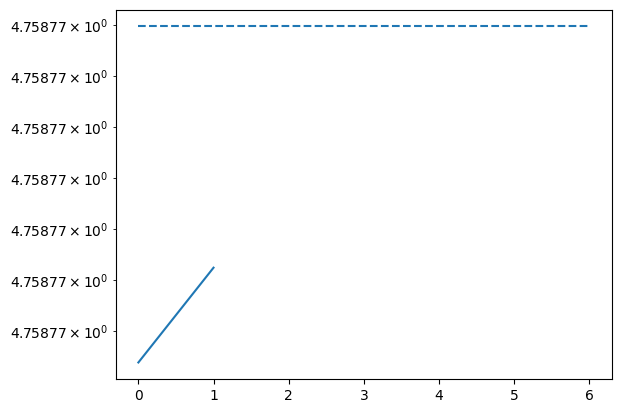

In [22]:
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
H = H_ising_gen(L=4, op_l=Z, op_t=X, J=-1, h_l=0, h_t=1)
e,v = np.linalg.eig(H)
print(e[0], e[0]**2+1-2*e[0])
plt.plot(np.abs(energies))
plt.hlines(y=np.abs(e[0]), xmin=0, xmax=6, linestyle='--')
plt.semilogy()

In [23]:
np.abs((energies[-1] - e[0])/energies[-1])

4.966212238093735e-07

In [24]:
energies

[array(-4.75876719), array(-4.75876812)]

In [17]:
spin = MPS(L=4, d=2, model="Ising", chi=4, J=1, h=1, eps=0)
spin._random_state(seed=3, chi=4)
spin.canonical_form()
energies = spin.sweeping(trunc=True)
print(energies)

Time of env contraction: 0.0016772720000517438
Sweep n: 0

Time of H_eff contraction: 0.0005927530000917614
Time of H_eff reshaping: 0.00032288500005961396
Time of eigsh during eigensolver for site 1: 1.1021044129993243
Time of svd during update state during sweeping right for site 1: 0.0006332440007099649
Total time of state updating: 0.0008667049996802234
Time of env updating: 0.0008356719999937923

Time of site 1 optimization: 1.1048764639999717

Time of H_eff contraction: 0.0004791830006070086
Time of H_eff reshaping: 0.00031408300037583103
Time of eigsh during eigensolver for site 2: 0.0009176809999189572
Time of svd during update state during sweeping right for site 2: 0.00041022500045073684
Total time of state updating: 0.00103007500001695
Time of env updating: 0.0008948039994720602

Time of site 2 optimization: 0.0036992710001868545

Time of H_eff contraction: 0.0006008919999658247
Time of H_eff reshaping: 0.0004028169996672659
Time of eigsh during eigensolver for site 3: 0.000

In [18]:
np.abs((energies[-1] - e[0])/energies[-1])

7.465612580780707e-16